In [1]:
from typing import Any, Optional

import ase
import numpy
from ase.calculators.calculator import Calculator
from sella import Constraints, Internals, Sella


def sella_optimize(
    atms_obj: ase.Atoms,
    calc: Calculator,
    order: int = 0,
    ints_obj: Optional[Internals] = None,
    in_place: bool = False,
) -> ase.Atoms:
    """Optimize a geometry using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param order: 0 = minimum | 1 = saddle point
    :param ints_obj: A Sella Internals object, possibly involving constraints
    :param in_place: Modify the atoms object in place?
    """
    if not in_place:
        atms_obj = atms_obj.copy()

    atms_obj.calc = calc

    # Initialize and run the optimization
    dyn = Sella(
        atms_obj, order=order, internal=(True if ints_obj is None else ints_obj)
    )
    dyn.run()

    return atms_obj


def sella_optimize_minimum(
    atms_obj: ase.Atoms, calc: Calculator, in_place: bool = False
) -> ase.Atoms:
    """Optimize a minimum-energy structure using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param in_place: Modify the atoms object in place?
    """
    return sella_optimize(atms_obj, calc, order=0, in_place=in_place)


def sella_optimize_ts(
    atms_obj: ase.Atoms, calc: Calculator, in_place: bool = False
) -> ase.Atoms:
    """Optimize a TS/saddle-point structure using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param in_place: Modify the atoms object in place?
    """
    return sella_optimize(atms_obj, calc, order=1, in_place=in_place)


def sella_optimize_constrained(
    atms_obj: ase.Atoms,
    calc: Calculator,
    const_coos: Optional[list[tuple[int, ...]]] = None,
    in_place: bool = False,
) -> ase.Atoms:
    """Optimize a structure subject to internal coordinate constraints using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param const_coos: Optionally, constrain a set of coordinates
    :param in_place: Modify the atoms object in place?
    """
    if not in_place:
        atms_obj = atms_obj.copy()

    # Set up constraints
    const_obj = Constraints(atms_obj)
    for coo in const_coos:
        if len(coo) == 2:
            const_obj.fix_bond(coo)
        elif len(coo) == 3:
            const_obj.fix_angle(coo)
        elif len(coo) == 4:
            const_obj.fix_dihedral(coo)

    # Set up internal coordinates
    ints_obj = Internals(atms_obj, cons=const_obj)
    ints_obj.find_all_bonds()
    ints_obj.find_all_angles()
    ints_obj.find_all_dihedrals()

    # Note: For whatever reason, the Atoms object must be identical to the one passed in
    # to Constraints and Internals, so we *must* set in_place=True here
    return sella_optimize(atms_obj, calc, ints_obj=ints_obj, in_place=True)

In [2]:
import automol


def scan_relaxed(
    geo,
    calc: Calculator,
    scan_coos: Optional[list[tuple[int, ...]]] = None,
    scan_grids: Optional[list[numpy.ndarray]] = None,
    const_coos: Optional[list[tuple[int, ...]]] = None,
    gra: Optional[Any] = None,
) -> tuple[numpy.ndarray, numpy.ndarray]:
    """Perform a relaxed scan with constraints using Sella

    :param geo: An AutoMol molecular geometry data structure
    :param calc: An ASE Calculator object
    :param scan_coos: The set of coordinates to scan over
    :param scan_grids: The grids of coordinate values for the scan
    :param const_coos: Optionally, constrain a set of coordinates
    :param gra: The molecular graph, for setting coordinate values
    :return: The geometries and energies, as arrays over the scan grid
    """
    all_const_coos = list(scan_coos) + list(const_coos)

    shape = numpy.shape(scan_grids[0])
    geo_grid = numpy.empty(shape, dtype=numpy.object_)
    ene_grid = numpy.empty(shape, dtype=numpy.float_)

    for idx in numpy.ndindex(shape):
        for coo, grid in zip(scan_coos, scan_grids):
            assert len(coo) == 2, "For now, only allowing bond coordinate scans"
            geo = automol.geom.set_distance(geo, coo, grid[idx], gra=gra, angstrom=True)

        atms_obj0 = automol.geom.ase_atoms(geo)
        atms_obj = sella_optimize_constrained(atms_obj0, calc, const_coos=all_const_coos)
        geo = automol.geom.from_ase_atoms(atms_obj)

        geo_grid[idx] = geo
        ene_grid[idx] = atms_obj.get_total_energy()

    return geo_grid, ene_grid

In [3]:
from scipy import interpolate


def scan_saddle_point_index(scan_grids, ene_grid) -> tuple[int, ...]:
    """Determine the index of the saddle point from the scan data"""
    assert len(scan_grids) == 1, "2D scans not yet implemented"

    (scan_grid,) = scan_grids

    # Underscores mark values sorted by scan coordinate value
    idxs_ = numpy.argsort(scan_grid)
    ene_grid_ = ene_grid[idxs_]

    # Check for delta sign changes to find the roots
    deltas = numpy.diff(ene_grid_, prepend=ene_grid_[0])
    signs = numpy.sign(deltas)
    (root_idxs_,) = numpy.where(numpy.diff(signs))
    print("root_idxs_:", root_idxs_)

    saddle_idx_ = None
    for root_idx_ in root_idxs_:
        neg_before = numpy.all(deltas[root_idx_ - 1 : root_idx_ + 1] > 0.0)
        pos_after = numpy.all(deltas[root_idx_ + 1 : root_idx_ + 3] < 0.0)
        if neg_before and pos_after:
            saddle_idx_ = root_idx_

    if saddle_idx_ is None:
        saddle_idx_ = numpy.argmax(ene_grid_)

    saddle_idxs = (idxs_[saddle_idx_],)
    return saddle_idxs

In [4]:
from tblite.ase import TBLite

calc = TBLite(method="GFN1-xTB", verbosity=0)

# 0. Define the reaction by SMILES
# # UNIMOLECULAR
# # hydrogen migration                                  #   (OK)
# rsmi, psmi = ("CCCO[O]", "[CH2]CCOO")                 #   (OK)
# # hydrogen migration (2TS)                            #   (OK)
# rsmi, psmi = ("CCC[CH2]", "CC[CH]C")                  #   (OK)
# # beta scission (stereo-specific)                     #   (X - bad TS)
# rsmi, psmi = ("F[CH][C@H](O)F", r"F/C=C\F.[OH]")      #   (X - bad TS)
# # beta scission                                       #   (X - need dummy atoms)
# rsmi, psmi = ("[CH2]/C=[C]/C#C", "C=C=C=C=[CH].[H]")  #   (X - need dummy atoms)
# # beta scission (intramolecular)                      #   (OK)
# rsmi, psmi = ("C[C]1O[C@H]1COO", r"C/C([O])=C\COO")   #   (OK)
# ring-forming scission (FIXED)
rsmi, psmi = ("[CH2]CCCOO", "C1CCCO1.[OH]")
# rsmi, psmi = (r"[CH2]/C=C\[C@@H](CC)OO", "CC[C@H]1OCC=C1.[OH]")
# # ring-forming scission with spiro atoms
# rsmi, psmi = ("CC1[C](O1)COO", "CC1C2(O1)CO2.[OH]")
# rsmi, psmi = ("CC1[C](OC1)CCOO", "CC1C2(OC1)CCO2.[OH]")
# # elimination
# rsmi, psmi = ("CCCCO[O]", "CCC=C.O[O]")
# # elimination (HONO)
# rsmi, psmi = ("CCCON(=O)=O", "CCC=O.N(=O)O")
# # BIMOLECULAR
# # hydrogen abstraction
# rsmi, psmi = ("CCO.[CH3]", "[CH2]CO.C")
# # hydrogen abstraction (sigma)
# rsmi, psmi = ("CCO.C#[C]", "CC[O].C#C")
# # hydrogen abstraction (radical radical)
# rsmi, psmi = ("CCC.[H]", "CC[CH2].[HH]")
# # addition
# rsmi, psmi = ("CC[CH2].[O][O]", "CCCO[O]")
# # addtition (internal / unimolecular)
# rsmi, psmi = ("CC([O])C=C", "CC(O1)C1[CH2]"),  # not bimolecular
# # addition (H + H => H2)
# rsmi, psmi = ("[H].[H]", "[H][H]")
# # addition (stereo-specific)
# rsmi, psmi = (r"F/C=C\F.[OH]", "F[CH][C@H](O)F")
# # addition (stereo-specific with ring)
# rsmi, psmi = ("C1C=C1.[OH]", "C1[CH][C@H]1(O)")
# # addition (vinyl radical)
# rsmi, psmi = (r"F\N=[C]/F.[C]#C", r"F\N=C(C#C)/F")
# # addition (vinyl and sigma radicals)
# rsmi, psmi = ("FC=[N].[C]#C", r"F/C=N\C#C")
# # addition (two vinyl radicals) (FIXED)
# rsmi, psmi = (r"F/C=[C]/[H].[H]/[C]=C/F", r"F/C=C\C=C/F")
# # addition (case 2)
# rsmi, psmi = ("C=CCCCCCC.[CH2]C", "CCC[CH]CCCCCC")
# # addition (radical radical 1)
# rsmi, psmi = ("CC[CH2].[H]", "CCC")
# # addition (radical radical 2) (FIXED)
# rsmi, psmi = ("[H].[OH]", "O")
# # addition (radical radical 3)
# rsmi, psmi = ("[CH3].[OH]", "CO")
# # addition (isc??)
# rsmi, psmi = ("N#N.[O]", "[N-]=[N+]=O")
# # substitution (Sn2) (FIXED)
# rsmi, psmi = ("[C@H](O)(C)F.[Cl]", "[C@@H](O)(C)Cl.[F]")
# # substitution (FIXED)
# rsmi, psmi = ("CO.[CH2]C", "CCC.[OH]")
# # insertion
# rsmi, psmi = ("CCC=C.O[O]", "CCCCO[O]")
# # insertion (HONO)
# rsmi, psmi = ("CCC=O.N(=O)O", "CCCON(=O)=O")
rsmis = automol.smiles.split(rsmi)
psmis = automol.smiles.split(psmi)

# 1. Find minimum energy geometries for the reactants
ratms_objs = list(map(automol.geom.ase_atoms, map(automol.smiles.geometry, rsmis)))
ratms_objs = [sella_optimize_minimum(o, calc=calc) for o in ratms_objs]
rgeos = list(map(automol.geom.from_ase_atoms, ratms_objs))

# 2. Map the reaction
rxn, *_ = automol.reac.from_smiles(rsmis, psmis, stereo=False)

# 3. Generate a TS guess structure
rxn = automol.reac.with_structures(rxn, "geom", rct_strucs=rgeos)
ts_gra = automol.reac.ts_graph(rxn)
geo0 = automol.reac.ts_structure(rxn)

scan_coos = automol.reac.scan_coordinates(rxn)
scan_vals = automol.reac.scan_values(rxn)
scan_grids = numpy.meshgrid(*scan_vals)
const_coos = automol.reac.constraint_coordinates(rxn)

# 4. Do a relaxed scan over the reaction coordinate
geo_grid, ene_grid = scan_relaxed(
    geo=geo0,
    calc=calc,
    scan_coos=scan_coos,
    scan_grids=scan_grids,
    const_coos=const_coos,
    gra=ts_gra,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/avcopan/code/amech-dev/src/autochem/sella-repo/notebook-examples/.pixi/envs/default/lib/python3.12/site-packages/ase/optimize/optimize.py:372: FutureWarning: force_consistent keyword is deprecated and will be ignored.  This will raise an error in future versions of ASE.
  warnings.warn(


     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 16:43:36     -612.619061       1.5480       0.0000       0.1000       1.0000
Sella   1 16:43:40     -612.745415       0.6547       0.0000       0.1000       1.1563
Sella   2 16:43:42     -612.765670       0.3343       0.0000       0.1000       0.7468
Sella   3 16:43:43     -612.770783       0.0726       0.0000       0.1000       1.0908
Sella   4 16:43:45     -612.772384       0.0559       0.0000       0.1000       1.4604
Sella   5 16:43:46     -612.773581       0.0334       0.0000       0.1000       1.1744


/home/avcopan/code/amech-dev/src/autochem/sella-repo/notebook-examples/.pixi/envs/default/lib/python3.12/site-packages/ase/optimize/optimize.py:372: FutureWarning: force_consistent keyword is deprecated and will be ignored.  This will raise an error in future versions of ASE.
  warnings.warn(


     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 16:43:55     -610.882152       4.0323       0.0000       0.1000       1.0000
Sella   1 16:43:59     -611.464488       2.3946       0.0005       0.1000       1.1142
Sella   2 16:44:02     -611.718733       1.6463       0.0009       0.1000       1.0726
Sella   3 16:44:04     -611.890378       1.1634       0.0008       0.1150       1.0300
Sella   4 16:44:07     -612.015774       0.8150       0.0007       0.1322       1.0013
Sella   5 16:44:09     -612.097154       0.5357       0.0005       0.1521       1.0026
Sella   6 16:44:11     -612.153293       0.3341       0.0003       0.1749       1.0101
Sella   7 16:44:13     -612.192778       0.2334       0.0002       0.2011       1.0163
Sella   8 16:44:16     -612.221171       0.1746       0.0001       0.2313       1.0287
Sella   9 16:44:18     -612.241514       0.1404       0.0001       0.2313       1.0563
Sella  10 16:44:22     -612.255096       0.

In [5]:
saddle_idxs = scan_saddle_point_index(scan_grids, ene_grid)
ts_geo0 = geo_grid[saddle_idxs]

ts_atms_obj0 = automol.geom.ase_atoms(ts_geo0)
ts_atms_obj = sella_optimize_ts(ts_atms_obj0, calc)
ts_geo = automol.geom.from_ase_atoms(ts_atms_obj)

root_idxs_: [0]
     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 16:45:09     -610.938723       3.4380       0.0000       0.1000       1.0000
Sella   1 16:45:13     -611.115083       2.7733       0.0000       0.1150       0.9894
Sella   2 16:45:15     -611.402252       2.7632       0.0000       0.1322       0.9851
Sella   3 16:45:17     -611.777862       2.8492       0.0000       0.1521       0.9723
Sella   4 16:45:19     -612.129822       2.0342       0.0000       0.1521       0.7604
Sella   5 16:45:22     -612.269910       0.8062       0.0000       0.1521       0.7275
Sella   6 16:45:24     -612.396491       0.8010       0.0000       0.1521       0.9190
Sella   7 16:45:27     -612.461804       0.3386       0.0000       0.1521       1.2354
Sella   8 16:45:29     -612.486891       0.3376       0.0000       0.1521       0.8386
Sella   9 16:45:31     -612.500274       0.2473       0.0000       0.1521       0.8392
Sella  10 16:45:33     -612

root_idxs_: [0]
(6,)


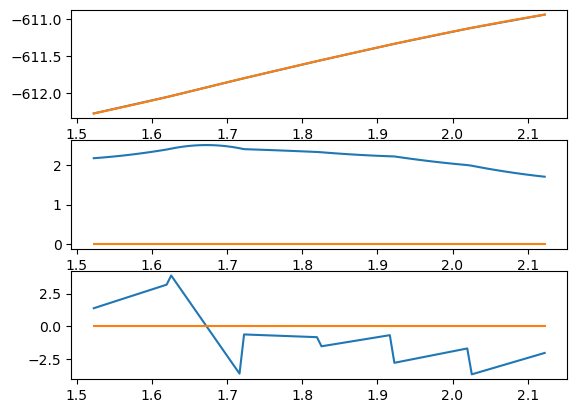

In [6]:
from matplotlib import pyplot

print(scan_saddle_point_index(scan_grids, ene_grid))

scan_grid, = scan_grids
idxs_ = numpy.argsort(scan_grid)
x_points = scan_grid[idxs_]
ene_grid_ = ene_grid[idxs_]

y = interpolate.Akima1DInterpolator(x_points, ene_grid_)
x = numpy.linspace(numpy.min(*scan_grids), numpy.max(*scan_grids), 100)

fig, ax = pyplot.subplots(3)
ax[0].plot(*scan_grids, ene_grid)
ax[0].plot(x, y(x))
ax[1].plot(x, y(x, nu=1))
ax[1].plot(x, numpy.zeros_like(x))
ax[2].plot(x, y(x, nu=2))
ax[2].plot(x, numpy.zeros_like(x))
pyplot.show()

In [7]:
# Visualize the results
def log_geometry_info(geo, scan_coos, const_coos, gra=None):
    """Print and display information about a geometry

    :param geo: An automol geometry data structure
    :param coo: The reaction/scan coordinate
    :param const_coos: Any constrained coordinates
    """
    # Display the geometry
    automol.geom.display(geo, gra=None)

    # Print distances for the scan coordinates
    print("Scan coordinates:")
    for coo in scan_coos:
        val = automol.geom.measure(geo, coo, angstrom=True, degree=True)
        print(f" - {coo}: {val}")

    # Print distances for the constraint coordinates
    print("Constraint coordinates:")
    for coo in const_coos:
        val = automol.geom.measure(geo, coo, angstrom=True, degree=True)
        print(f" - {coo}: {val}")


automol.graph.display(ts_gra, label=True, exp=True)

print("\nStarting geometry:")
log_geometry_info(geo0, scan_coos, const_coos, gra=ts_gra)

print("\nScan saddle geometry:")
ene = ene_grid[saddle_idxs]
log_geometry_info(ts_geo0, scan_coos, const_coos, gra=ts_gra)
print("Energy:", ene)
print("*** ***\n")

print("\nTS geometry:")
log_geometry_info(ts_geo, scan_coos, const_coos, gra=ts_gra)


Starting geometry:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (6, 7): 1.422590621950753
Constraint coordinates:
 - (0, 3, 4): 105.70452323926399
 - (3, 4, 5): 110.7581275244956
 - (4, 5, 6): 92.99912904583583
 - (0, 3, 4, 5): 280.8493160530758
 - (3, 4, 5, 6): 48.961294539029936
 - (4, 5, 6, 7): 181.65133928014225

Scan saddle geometry:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (6, 7): 2.1225905504155906
Constraint coordinates:
 - (0, 3, 4): 105.70461283519599
 - (3, 4, 5): 110.75769577812909
 - (4, 5, 6): 92.99939206104594
 - (0, 3, 4, 5): 280.8492648910917
 - (3, 4, 5, 6): 48.96125277031046
 - (4, 5, 6, 7): 181.65136926235672
Energy: -610.9387231206907
*** ***


TS geometry:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (6, 7): 1.5853175960764518
Constraint coordinates:
 - (0, 3, 4): 107.2549324878975
 - (3, 4, 5): 107.1578097913182
 - (4, 5, 6): 108.0442303731802
 - (0, 3, 4, 5): 312.20891128400973
 - (3, 4, 5, 6): 45.01809227545239
 - (4, 5, 6, 7): 165.19396252076737


In [10]:
atms_obj = automol.geom.ase_atoms(ts_geo)
atms_obj.calc = calc
atms_obj

Atoms(symbols='CH2C3O2H7', pbc=False, calculator=TBLite(...))

In [11]:
from ase.vibrations import Vibrations

vib_obj = Vibrations(atms_obj)
vib_obj.run()
vib_obj.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   74.9i    604.1i
  1    1.8i     14.7i
  2    0.0i      0.1i
  3    0.0i      0.1i
  4    0.1       0.5
  5    0.5       4.3
  6    0.8       6.8
  7    9.2      74.0
  8   15.2     122.6
  9   21.8     176.0
 10   28.8     232.7
 11   33.7     272.1
 12   48.6     392.2
 13   66.4     535.9
 14   67.3     542.4
 15   70.4     567.6
 16   90.9     733.2
 17  100.5     810.6
 18  106.9     862.0
 19  114.3     922.1
 20  116.8     942.4
 21  122.5     988.2
 22  132.0    1064.3
 23  136.7    1102.2
 24  139.1    1122.0
 25  143.0    1153.0
 26  144.4    1164.8
 27  149.9    1209.1
 28  154.5    1246.4
 29  161.0    1298.2
 30  162.9    1314.2
 31  166.3    1341.4
 32  172.2    1388.9
 33  179.9    1450.8
 34  180.5    1455.9
 35  182.8    1474.8
 36  366.8    2958.7
 37  368.7    2973.4
 38  372.2    3002.1
 39  375.0    3024.4
 40  376.1    3033.5
 41  378.6    3053.9
 42  387.4    3124.7
 43  395.3    3188.2
 44  45

In [12]:
vib_obj.get_mode(0)

array([[-0.1476679 , -0.02827057,  0.03123653],
       [-0.03646563, -0.01340783,  0.02257823],
       [-0.02311736, -0.0132831 , -0.00519119],
       [-0.00985807, -0.0028671 ,  0.00369913],
       [ 0.00999276, -0.02742506, -0.00025034],
       [ 0.0311556 ,  0.01708947, -0.00436633],
       [ 0.17859012, -0.0074277 , -0.03064991],
       [-0.08952213,  0.03156219,  0.00489416],
       [ 0.00018144,  0.07381144,  0.00932308],
       [ 0.00902731,  0.00079807,  0.00183876],
       [ 0.01200647, -0.02560657, -0.00097962],
       [ 0.02031023, -0.02473618, -0.00680918],
       [ 0.02557372,  0.0785529 ,  0.01240046],
       [ 0.00475342,  0.01298843,  0.00662931],
       [-0.03291727,  0.01674387,  0.00160349]])